# Comparing Clustering Quality Metrics

In [a previous notebook called "Weaponizing the randomness of k-means"](https://github.com/pbalm/mlbits/blob/master/Weaponizing%20the%20randomness%20of%20k-means.ipynb) I introduced the metrics "cluster confidence" and "cluster stability" for k-means output. Clustering algorithms in general suffer randomness in their output due to finite sample size, and in case of k-means, due the initialization as well. Due to this randomness, not all clusters will be found in every run of k-means, and the clusters centroids will vary. "Cluster confidence" and "cluster stability" attempt to capture this variance. Judging from a toy dataset, the Iris dataset (plant measurements) and the MNIST dataset (10 clusters), the metrics perform well as long as the dataset is large enough to permit reliable clustering on 5-10% of the total dataset.

This notebook is a continuation of the work in the "Weaponizing" notebook, and not everything here will make sense without having read that.

I have already compared to the more traditional "elbow method". The elbow method scales well to large datasets but often provides little help in determining the number of clusters, and moreover, it does not provide any indication of whether the clustering reflects actual structure in the data, or whether it was obtained by chance (as happens when the data has no structure).

Here I will compare the Silhouette index and the Adjusted RAND Index as suggested by Dolnicar (Journal of Travel Research 2018, Vol 57(I) 69-82). Neither of these scale easily to large datasets, since both the Silhouette index and the RAND index are based on comparing pairs of points, and the time required to calculate them should scale with at least the square of the number of points. On large datasets it may therefore not be feasible to use these metrics, but it's interesting to compare how well they work on smaller datasets where they are feasible.

## Approach

The goal here is not to do an exhaustive study, but to get a feeling for how different metrics perform. I will use the  MNIST dataset [as before](https://github.com/pbalm/mlbits/blob/master/Weaponizing%20the%20randomness%20of%20k-means.ipynb), and I will determine the number of clusters first using the [Silhouette index](https://en.wikipedia.org/wiki/Silhouette_(clustering%29), and after that using the [adjusted RAND index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index) in an appproach similar to the one advocated by Dolnicar.

I'll show the elbow method again, for reference.

## Silhouette index

The k-means algorithm optimizes only cluster compactness, and does not take cluster separation into account. The Silhouette index measures both these concepts, which helps to give a better idea of the clustering quality. I'm following the same approach as in the [Silhouette index tutorial on the scikit-learn website](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), and I compare the results to the "cluster confidence" and "cluster stability" I have defined earlier.

Note that the clustering is done on a dataset reduced to 5 dimensions using PCA, not on the two-dimensional dataset that is visualized for reference. The Silhouette index is calculated from the same dataset used for clustering.

For n_clusters = 2 The average silhouette_score is : 0.226240460612


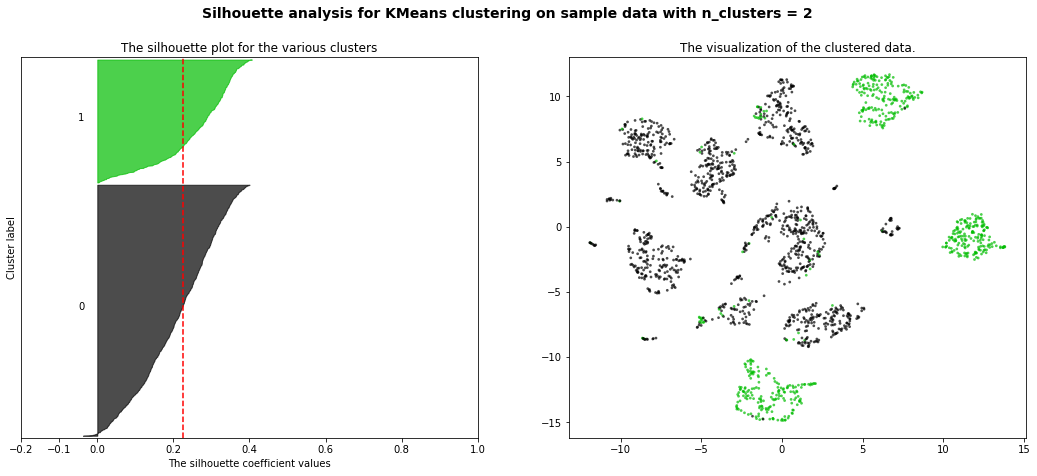

For n_clusters = 3 The average silhouette_score is : 0.228800008939


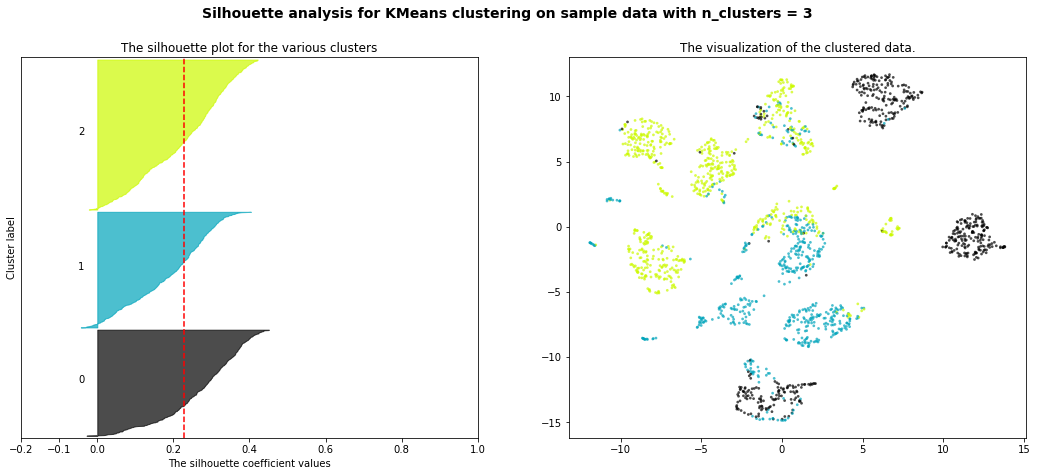

For n_clusters = 4 The average silhouette_score is : 0.232920164901


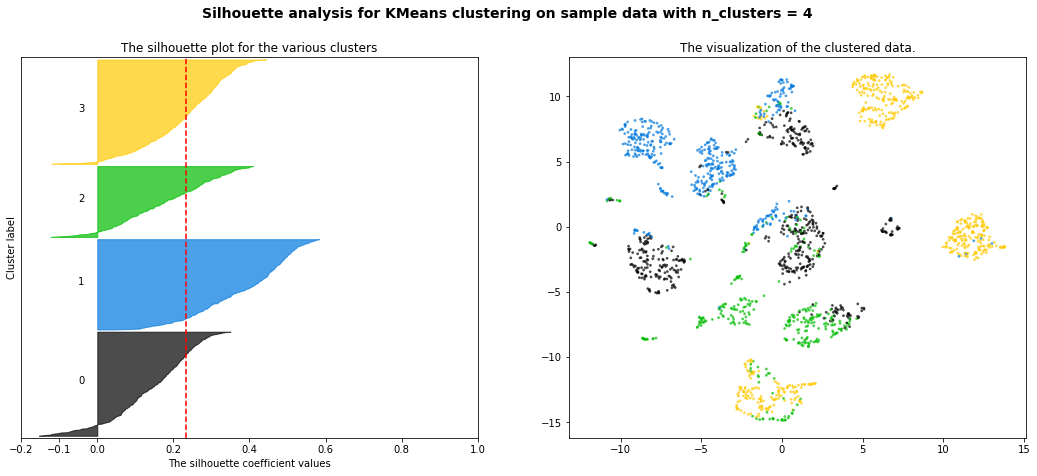

For n_clusters = 5 The average silhouette_score is : 0.251384880252


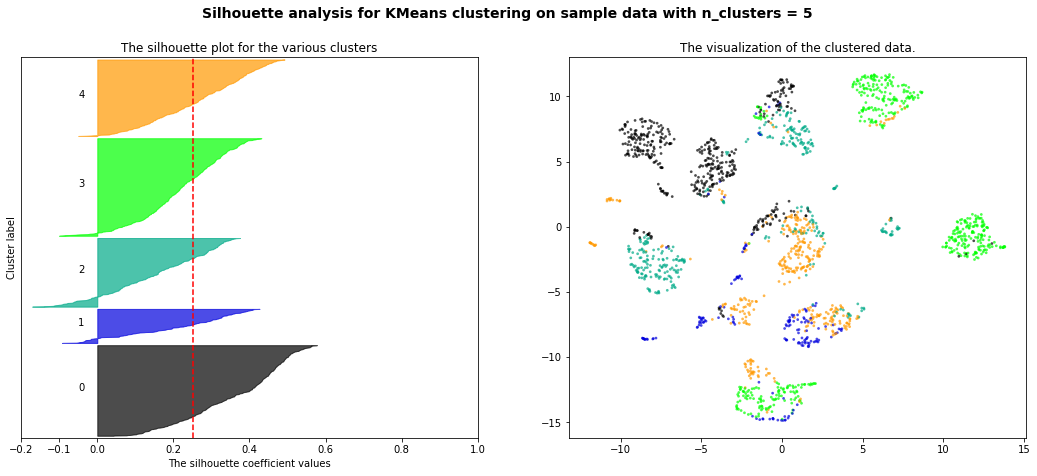

For n_clusters = 6 The average silhouette_score is : 0.274118190393


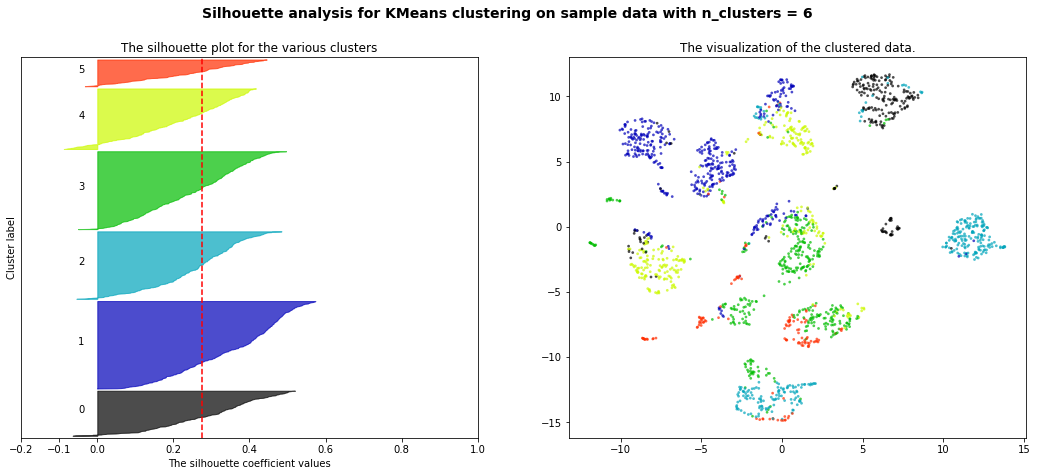

For n_clusters = 7 The average silhouette_score is : 0.283889071803


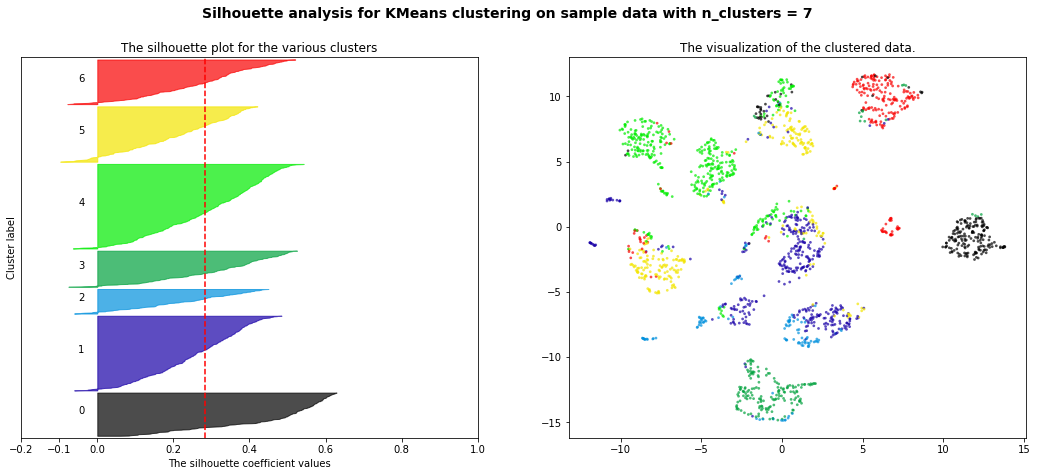

For n_clusters = 8 The average silhouette_score is : 0.289437648366


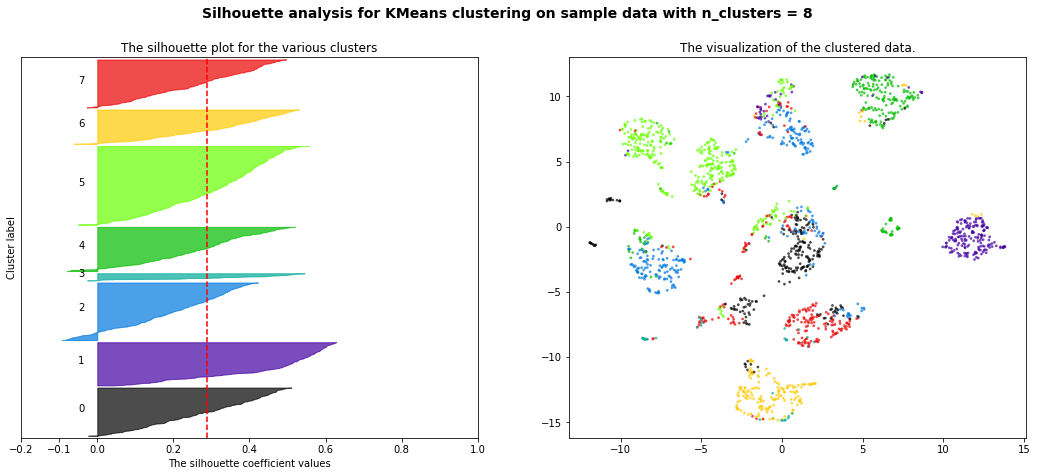

For n_clusters = 9 The average silhouette_score is : 0.30517091631


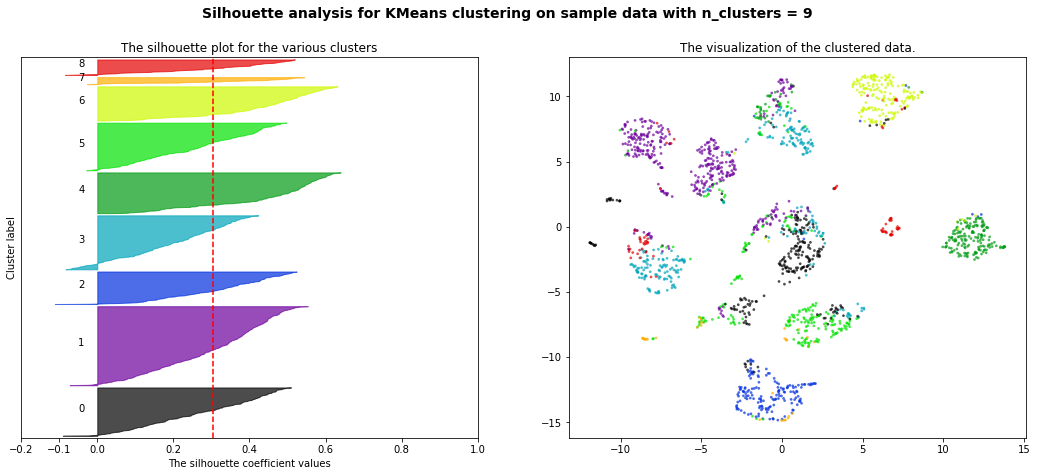

For n_clusters = 10 The average silhouette_score is : 0.31171205499


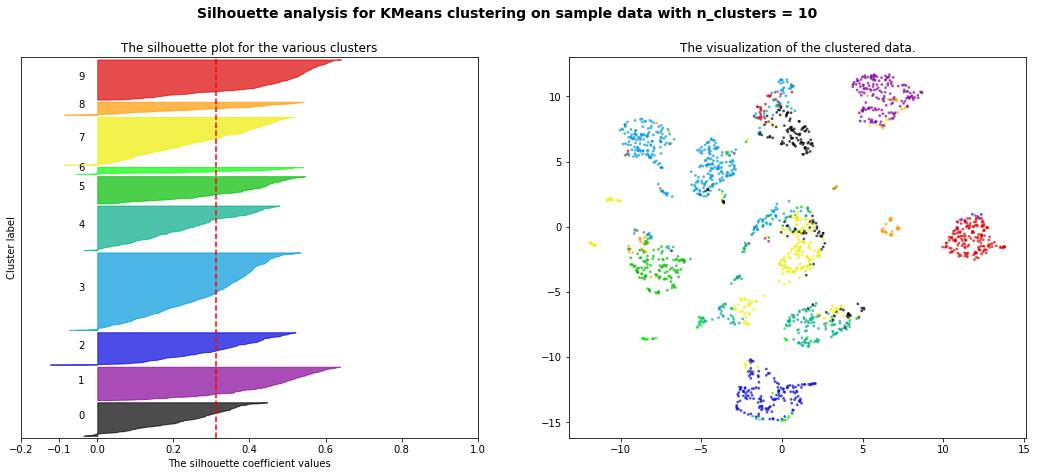

For n_clusters = 11 The average silhouette_score is : 0.320928639052


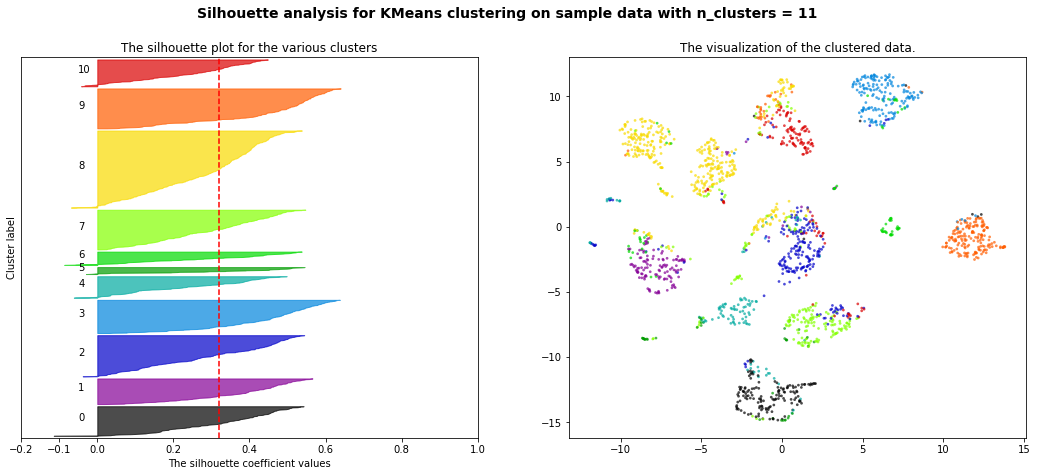

For n_clusters = 12 The average silhouette_score is : 0.309896448338


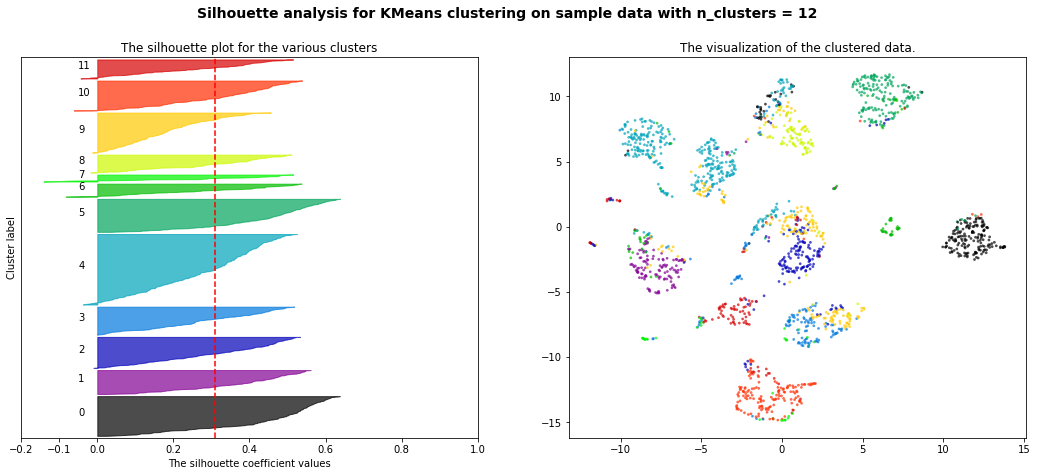

For n_clusters = 13 The average silhouette_score is : 0.287257328347


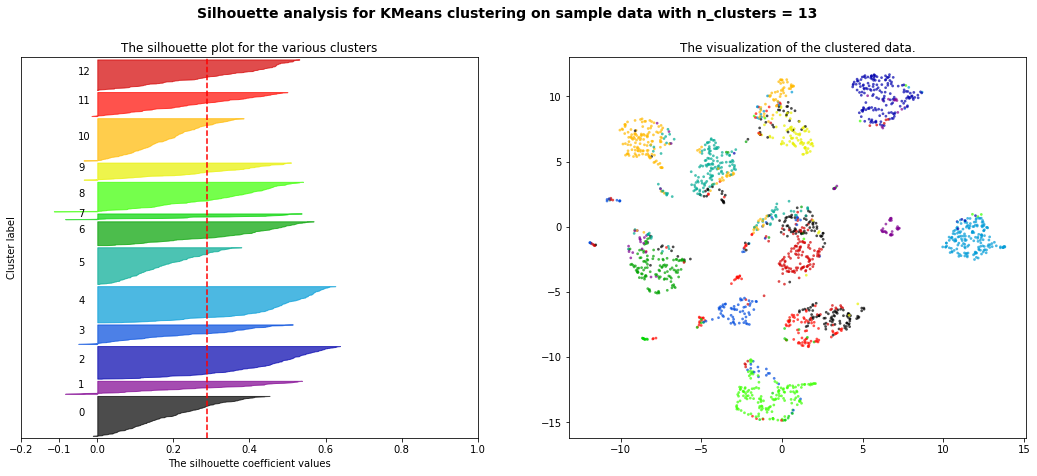

For n_clusters = 14 The average silhouette_score is : 0.283871961904


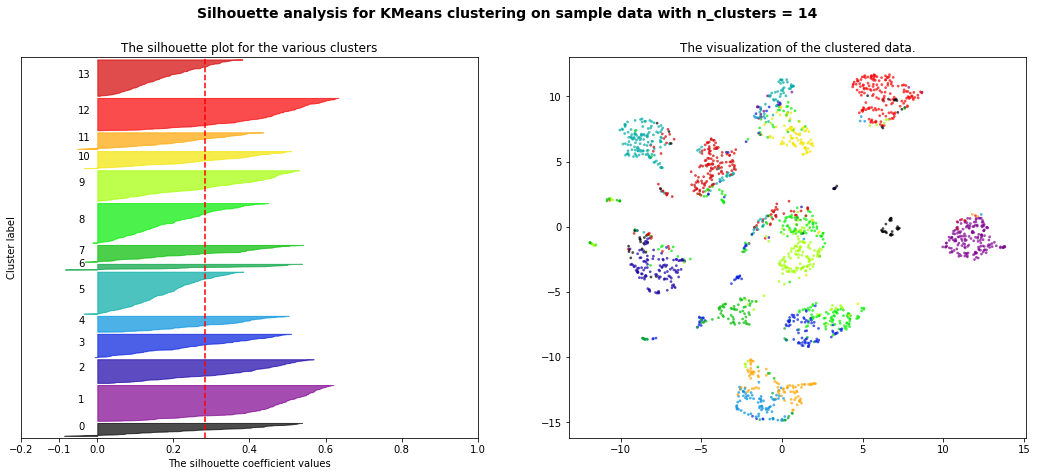

For n_clusters = 15 The average silhouette_score is : 0.281844219474


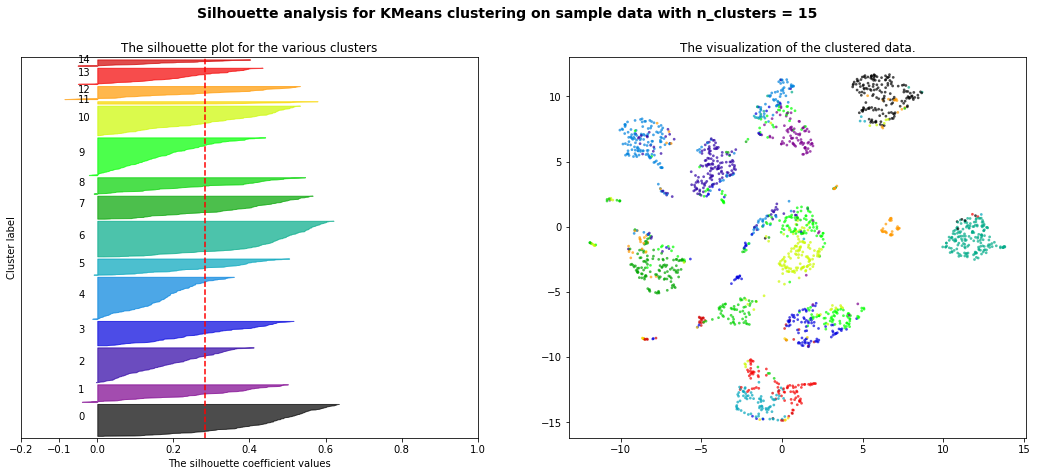

For n_clusters = 16 The average silhouette_score is : 0.283959984349


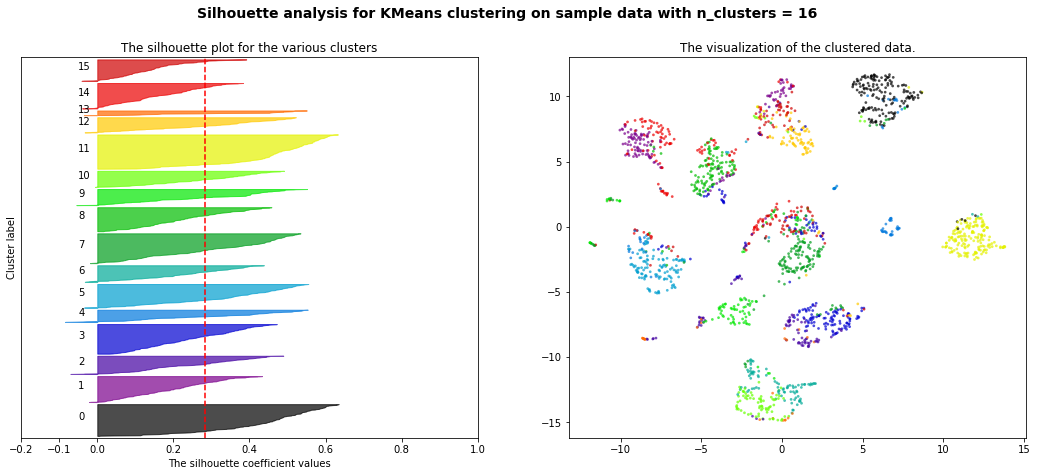

For n_clusters = 17 The average silhouette_score is : 0.265544232294


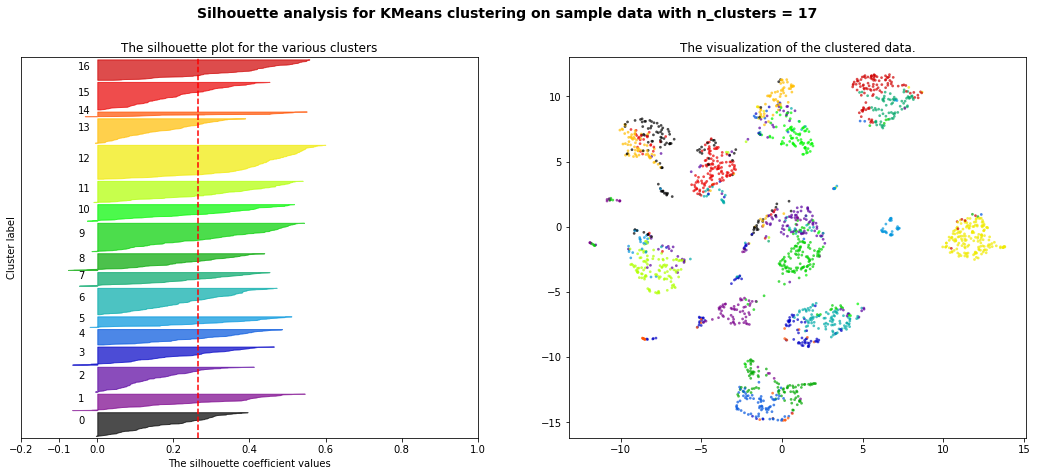

For n_clusters = 18 The average silhouette_score is : 0.267212533522


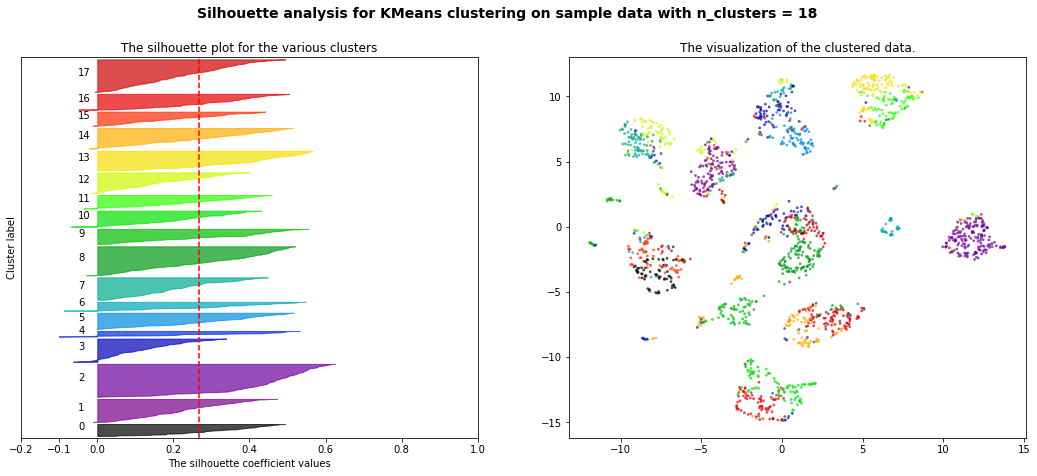

For n_clusters = 19 The average silhouette_score is : 0.257115989085


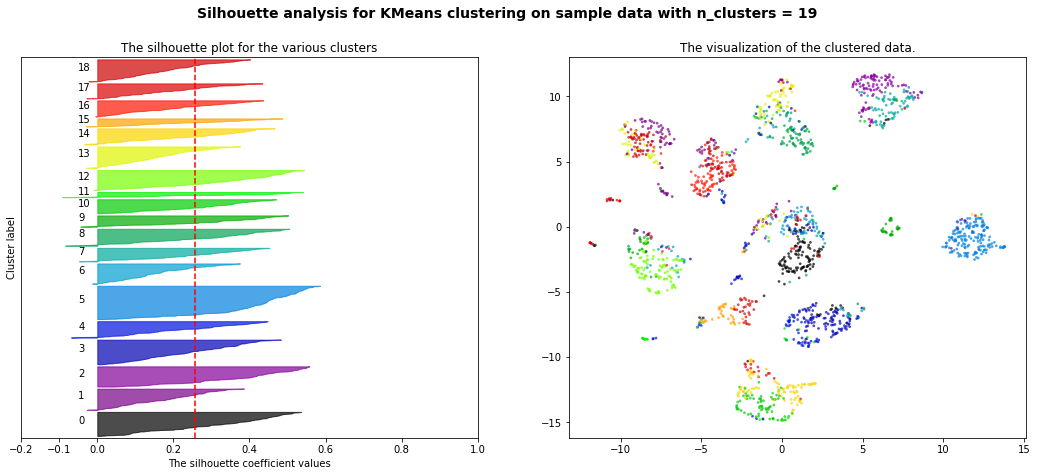

For n_clusters = 20 The average silhouette_score is : 0.252462864437


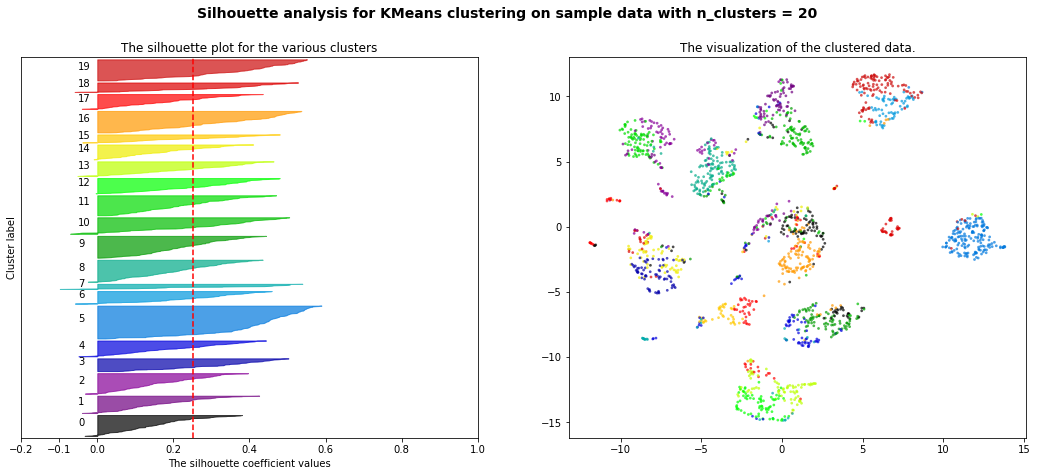

In [1]:
%matplotlib inline

from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from umap import UMAP


# Load MNIST data
(data, target) = load_digits(return_X_y=True)

# The data we will feed to K-means:
X = PCA(n_components=5).fit_transform(scale(data))

# Project onto 2-dimensional space using UMAP for visualization:
umapper = UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')
X_viz = umapper.fit_transform(data)
x_viz = [x[0] for x in X_viz]
y_viz = [x[1] for x in X_viz]

range_n_clusters = [k+2 for k in range(19)] # 2-20
scores = []

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.2, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_viz, y_viz, marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

### Silhouette Index Evaluation

For a broad range of k-values, such as above, that's a lot of data to digest. We are supposed to be evaluating how equally-sized all clusters are, whether any have negative Silhouette scores (a point with negative score is potentially assigned to the wrong cluster), and whether the average score is higher or lower.

Simply plotting the averages indicates that 11 clusters is the preferred number, according to the Silhouette index.

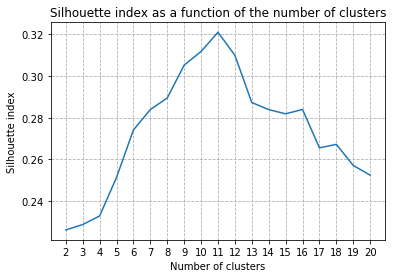

In [2]:
plt.plot(range_n_clusters, scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette index")
plt.xticks(range_n_clusters)
plt.grid(b=True, which='major', linestyle='--')
plt.title("Silhouette index as a function of the number of clusters")

## Adjusted RAND Index

The Adjusted RAND index is sometimes used to assess classification performace, using a known ground truth. It compares the level to which classes or clusters overlap, which higher scores meaning more overlap. As inspired by Dolnicar (see introduction for the reference), the approach is two run the clustering using a given number of cluster on the full dataset. We consider this the "true clustering" for this number of clusters. We then split the dataset in a number of folds (for the MNIST dataset we use 20 folds) and run the clustering on each fold. After each clustering, we can compare the clusters found on the fold to the "true clustering". If there is cluster structure in the dataset and we have chosen the number of clusters correctly, then we should replicate the "true clustering" on the folds. This will show high values for the ARI if the number of clusters is appropriate for the structure of the dataset.

Therefore, in the following code snippet, I will:

* use folds as in the ["Weaponizing" notebook](https://github.com/pbalm/mlbits/blob/master/Weaponizing%20the%20randomness%20of%20k-means.ipynb), 
* consider a clustering on the full dataset the "ground truth"
* use the RAND index to evaluate each fold

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import adjusted_rand_score

np.random.seed(0)

n_splits = 20

def getARI(X, range_n_clusters):
    ari = []
    ari_errors = []

    for k in range_n_clusters:
        kmeans = KMeans(k, n_jobs=-1, init='random')
    
        clusters_all = kmeans.fit_predict(X)
    
        kfold = KFold(n_splits=n_splits)
        ari_k = []
        for train_index, test_index in kfold.split(X):
            clusters_fold = kmeans.fit_predict(X[test_index])
            ari_fold = adjusted_rand_score(clusters_all[test_index], clusters_fold)
            ari_k.append(ari_fold)
    
        ari.append(np.average(ari_k))
        ari_errors.append(np.std(ari_k))
        
    return (ari, ari_errors)

ari, ari_errors = getARI(X, range_n_clusters)

### Adjusted RAND Index (ARI) Evaluation

Below I plot the average Adjusted Rand Index as a function of the number of clusters. This plot indicates (the triangles) that the clustering is most stable between 8 and 12 clusters, with 10 clusters being the best bet.

When I run k-means several times on different folds, due to the randomness from the finite sample size and the random initialization of k-means, different results and different values for the ARI are obtained. The solid line in the graph below indicates the standard deviation of the ARI scores, meaning that each time k-means is run, there is a 68% probability (1 sigma) that the ARI score will be between the solid lines. Our estimate of the mean ARI score is better than this, since it improves with the number of ARI scores we calculate. The accuracy of the mean ARI score is shown as the dotted line.

The accuracy of the mean ARI score shows that with 20 folds, the 

(0.5, 0.7)

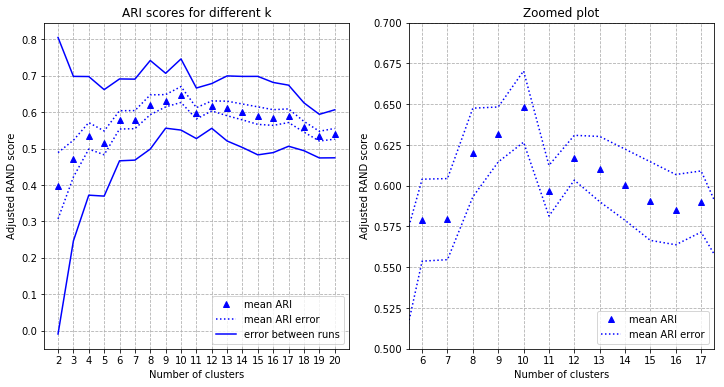

In [4]:
def plotARI(show_variance=True):
    lower = np.array(ari) - np.array(ari_errors)
    upper = np.array(ari) + np.array(ari_errors)

    stddev_on_mean = np.array(ari_errors)/np.sqrt(n_splits)
    mean_lower = np.array(ari) - stddev_on_mean
    mean_upper = np.array(ari) + stddev_on_mean
    
    if (show_variance):
        var_style = 'b-'
    else:
        var_style = 'None'

    ld, ll, lu, lml, lmu = plt.plot(range_n_clusters, ari, 'b^', \
         range_n_clusters, lower, var_style, \
         range_n_clusters, upper, var_style, \
         range_n_clusters, mean_lower, 'b:', \
         range_n_clusters, mean_upper, 'b:' \
         )
    plt.xlabel("Number of clusters")
    plt.ylabel("Adjusted RAND score")
    plt.xticks(range_n_clusters)
    plt.grid(b=True, which='major', linestyle='--')
    
    if (show_variance):
        plt.legend((ld, lml, ll), ("mean ARI", "mean ARI error", "error between runs"), loc="lower right")
    else:
        plt.legend((ld, lml), ("mean ARI", "mean ARI error"), loc="lower right")

# Start plotting:
plt.figure(1, figsize=(12, 6))    

plt.subplot(121)
plt.title("ARI scores for different k")
plotARI()

plt.subplot(122)
plt.title("Zoomed plot")
plotARI(False)
plt.xlim(5.5, 17.5)
plt.ylim(0.5, 0.7)

## Elbow method

For reference, let me bring up the elbow method again. In this method, the right number of cluster is found by looking for a kink or elbow in the graph. A kink is a location where the slope of the line changes, or put another way, where there is a peak in the curvature of the graph. The curvature of the plot is found by taking the second derivate of the graph, so I'll plot that too, as the solid black line.

Spoiler: There is nothing there. There is somewhat of a bump in the curvature at 11 clusters, which indicates a kink in the elbow curve. However, we should choose 3 clusters since this is where the curvature is maximized. The curvature at 4 and 6 clusters are also high, but I suspect this is an artifact due to the elbow score at 5 clusters coming out a bit high. If the point at 5 clusters moves up, then you're artificially creating somewhat of a kink at 4 and 6.

In [5]:
def get_elbow_scores(X, k_arr):
    elbow_scores = []
    for k in k_arr:
        kmeans = KMeans(k, init='random')
        kmeans.fit(X)
        elbow_scores.append(-kmeans.score(X))
    return elbow_scores

elbow_scores = get_elbow_scores(X, range_n_clusters)

Calculate the curvature:

In [6]:
curv_arr = []
for i in range(1, len(range_n_clusters)-1):
    slope1 = elbow_scores[i] - elbow_scores[i-1]
    slope2 = elbow_scores[i+1] - elbow_scores[i]
    curv = slope2 - slope1
    curv_arr.append(curv)  


Plot the result:

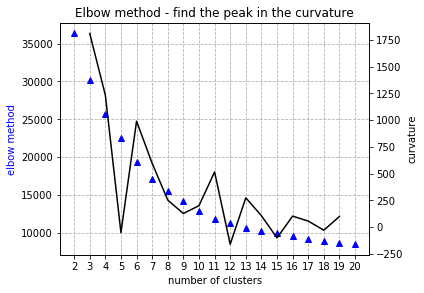

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(range_n_clusters, elbow_scores, 'b^')
ax1.set_xlabel('number of clusters')
ax1.set_xticks(range_n_clusters)
ax1.set_ylabel('elbow method', color='b')
ax1.grid(b=True, which='major', linestyle='--')

ax2 = ax1.twinx()
ax2.plot(range_n_clusters[1:-1], curv_arr, 'k-')
ax2.set_ylabel('curvature', color='k')

fig.tight_layout()
plt.title("Elbow method - find the peak in the curvature")
plt.show()

## Conclusions

I have looked at how the Silhouette index and the Adjusted Rand Index (ARI) as suggested by Dolnicar (see introduction for the reference) can be used to determine the number of clusters to use in combination with k-means. I have also compared to the elbow method and found it to be not helpful.

Compared to the cluster stability and cluster confidence metrics I defined [in a previous notebook](https://github.com/pbalm/mlbits/blob/master/Weaponizing%20the%20randomness%20of%20k-means.ipynb), the Silhouette index performs very well and the ARI performs comparably. However, as both these metrics are based on pair-wise comparison of data records (examples, data points), their CPU performance is expected to scale at least as the square of the number of records. Cluster stability and cluster confidence do not add Therefore, these metrics are not expected to be feasibly for large datasets.